In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [174]:
data_runs = pd.read_csv('runs.csv', sep=',', engine='python')

In [175]:
data_runs

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,time2,time3,time4,time5,time6,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,...,21.59,23.86,24.62,NaN,NaN,83.92,9.7,3.7,118,2
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,...,21.99,23.30,23.70,NaN,NaN,83.56,16.0,4.9,164,57
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,...,21.59,23.90,24.22,NaN,NaN,83.40,3.5,1.5,137,18
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,...,21.83,23.70,24.00,NaN,NaN,83.62,39.0,11.0,80,59
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,...,21.75,23.22,23.50,NaN,NaN,83.24,50.0,14.0,9,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,6348,10,1238,6,0.0,1.25,5,AUS,Gelding,87,...,23.98,23.53,22.52,NaN,NaN,96.17,99.0,NaN,73,40
79443,6348,11,985,7,0.0,2.25,5,NZ,Gelding,84,...,24.10,23.77,22.61,NaN,NaN,96.30,99.0,NaN,164,63
79444,6348,12,3147,10,0.0,3.00,5,NZ,Gelding,83,...,24.06,23.37,22.43,NaN,NaN,96.44,99.0,NaN,111,68
79445,6348,13,1982,8,0.0,2.50,3,AUS,Gelding,82,...,24.02,23.45,22.29,NaN,NaN,96.34,4.6,NaN,118,95


In [176]:
data_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   race_id          79447 non-null  int64  
 1   horse_no         79447 non-null  int64  
 2   horse_id         79447 non-null  int64  
 3   result           79447 non-null  int64  
 4   won              79447 non-null  float64
 5   lengths_behind   79447 non-null  float64
 6   horse_age        79447 non-null  int64  
 7   horse_country    79445 non-null  object 
 8   horse_type       79445 non-null  object 
 9   horse_rating     79447 non-null  int64  
 10  horse_gear       79447 non-null  object 
 11  declared_weight  79447 non-null  float64
 12  actual_weight    79447 non-null  int64  
 13  draw             79447 non-null  int64  
 14  position_sec1    79447 non-null  int64  
 15  position_sec2    79447 non-null  int64  
 16  position_sec3    79447 non-null  int64  
 17  position_sec

In [177]:
data_runs['horse_country'].unique()

array(['AUS', 'NZ', 'SAF', 'GB', 'USA', 'IRE', 'FR', 'CAN', nan, 'ARG',
       'GER', 'ZIM', 'JPN', 'BRZ', 'GR', 'ITY', 'SPA'], dtype=object)

In [178]:
data_runs['horse_type'].unique()

array(['Gelding', 'Mare', 'Horse', 'Brown', 'Rig', 'Colt', nan, 'Roan',
       'Filly', 'Grey'], dtype=object)

Видно, что столбцы horse_country и horse_type категориальные

In [179]:
data_runs.horse_country = data_runs.horse_country.astype('category')
data_runs.horse_type = data_runs.horse_type.astype('category')

Ещё удалим столбец horse_gear, так как он сложный для представления

In [180]:
data_runs.drop(['horse_gear'], axis=1, inplace=True)

Также удалим следующие столбцы, так как id, result и finish_time бесполезны в обучении

In [182]:
data_runs.drop(['result', 'race_id', 'horse_id', 'horse_no', 'trainer_id', 'jockey_id', 'finish_time'],axis=1, inplace=True)

In [185]:
data_runs.describe()

,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,draw,position_sec1,position_sec2,position_sec3,...,behind_sec5,behind_sec6,time1,time2,time3,time4,time5,time6,win_odds,place_odds
count,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,...,10079.000000,1296.000000,79447.000000,79447.000000,79447.000000,46226.000000,10079.000000,1296.000000,79447.000000,75712.000000
mean,0.080053,6.108901,3.339346,61.034904,1104.953568,122.729656,6.876005,6.849837,6.846791,6.843443,...,6.026654,10.638735,21.135438,22.928985,23.864054,24.039662,24.105221,24.350216,28.812977,7.423177
std,0.271378,33.636209,0.876763,11.748788,62.347597,6.305496,3.747589,3.734348,3.733014,3.732055,...,31.754623,67.791252,6.930518,3.599727,3.571163,4.663367,1.127963,1.314755,30.097375,8.823430
min,0.000000,-0.500000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,1.000000,...,0.100000,0.000000,12.390000,19.990000,21.000000,21.200000,21.420000,21.500000,1.000000,1.000000
25%,0.000000,1.750000,3.000000,60.000000,1062.000000,118.000000,4.000000,4.000000,4.000000,4.000000,...,1.750000,1.750000,14.120000,22.290000,23.230000,23.320000,23.410000,23.570000,7.700000,2.400000
50%,0.000000,4.000000,3.000000,60.000000,1102.000000,123.000000,7.000000,7.000000,7.000000,7.000000,...,3.750000,4.250000,24.180000,22.870000,23.760000,23.890000,23.960000,24.120000,15.000000,4.100000
75%,0.000000,6.750000,3.000000,60.000000,1146.000000,128.000000,10.000000,10.000000,10.000000,10.000000,...,6.500000,7.750000,25.360000,23.520000,24.410000,24.560000,24.630000,24.820000,38.000000,8.600000
max,1.000000,999.000000,10.000000,138.000000,1369.000000,133.000000,15.000000,14.000000,14.000000,14.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,49.570000,34.150000,99.000000,101.000000


In [186]:
print(data_runs.shape)
print(data_runs.columns)

(79447, 29)
Index(['won', 'lengths_behind', 'horse_age', 'horse_country', 'horse_type',
       'horse_rating', 'declared_weight', 'actual_weight', 'draw',
       'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4',
       'position_sec5', 'position_sec6', 'behind_sec1', 'behind_sec2',
       'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6', 'time1',
       'time2', 'time3', 'time4', 'time5', 'time6', 'win_odds', 'place_odds'],
      dtype='object')


<AxesSubplot:xlabel='horse_age', ylabel='count'>

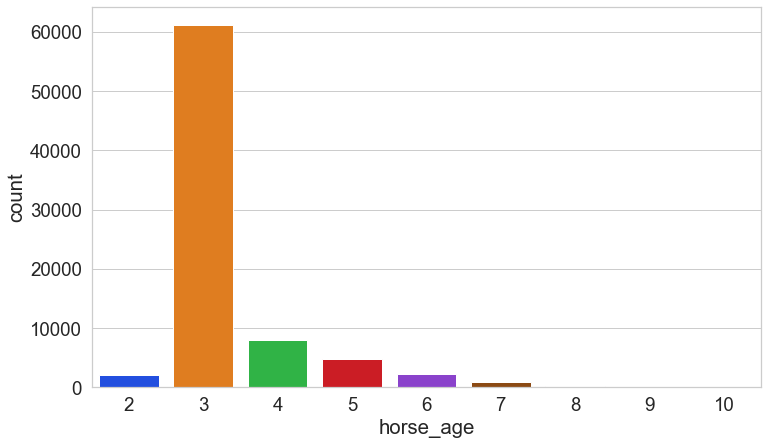

In [187]:
plt.figure(figsize=(12,7))
sns.countplot(data=data_runs, x='horse_age', palette='bright')

<AxesSubplot:xlabel='horse_country', ylabel='count'>

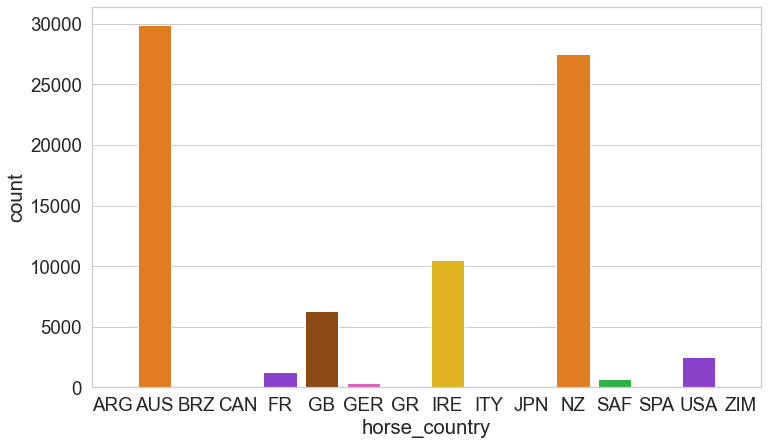

In [188]:
plt.figure(figsize=(12,7))
sns.countplot(data=data_runs, x='horse_country', palette='bright')

<AxesSubplot:xlabel='horse_type', ylabel='count'>

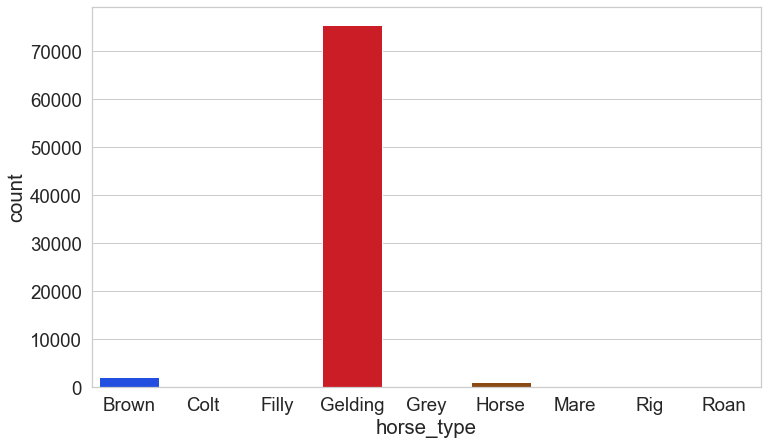

In [189]:
plt.figure(figsize=(12,7))
sns.countplot(data=data_runs, x='horse_type', palette='bright')

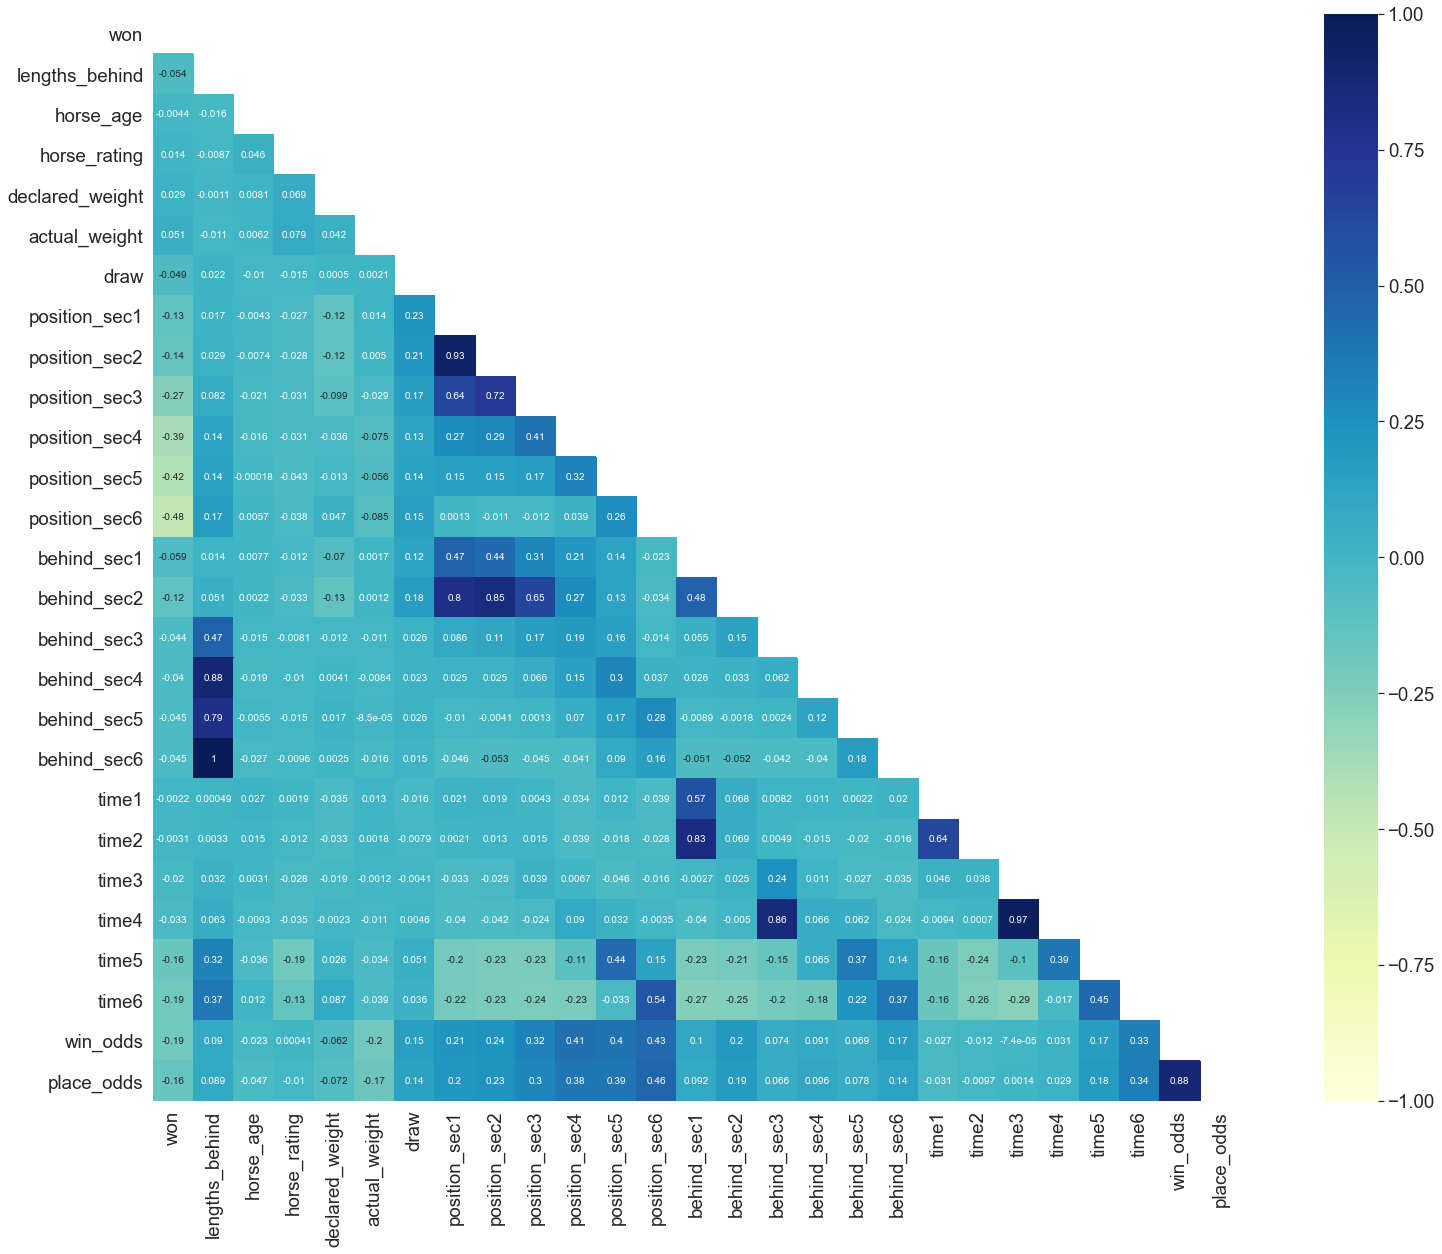

In [190]:
corr_matrix = data_runs.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(30,20))
    sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="YlGnBu", annot=True, mask=mask, square=True)

Рассмотрим значения, где корреляция больше 0.5

In [191]:
import numpy as np
corr_matrix.where(np.triu(corr_matrix > 0.5, k=1)).stack().sort_values(ascending = False)

lengths_behind  behind_sec6      0.999983
time3           time4            0.972970
position_sec1   position_sec2    0.928896
win_odds        place_odds       0.880301
lengths_behind  behind_sec4      0.876373
behind_sec3     time4            0.856275
position_sec2   behind_sec2      0.848470
behind_sec1     time2            0.829744
position_sec1   behind_sec2      0.799990
lengths_behind  behind_sec5      0.794927
position_sec2   position_sec3    0.724334
position_sec3   behind_sec2      0.646923
position_sec1   position_sec3    0.637941
time1           time2            0.635097
behind_sec1     time1            0.571686
position_sec6   time6            0.540960
dtype: float64

Теперь посмотрим, отношение значений столбца won

<AxesSubplot:xlabel='won', ylabel='count'>

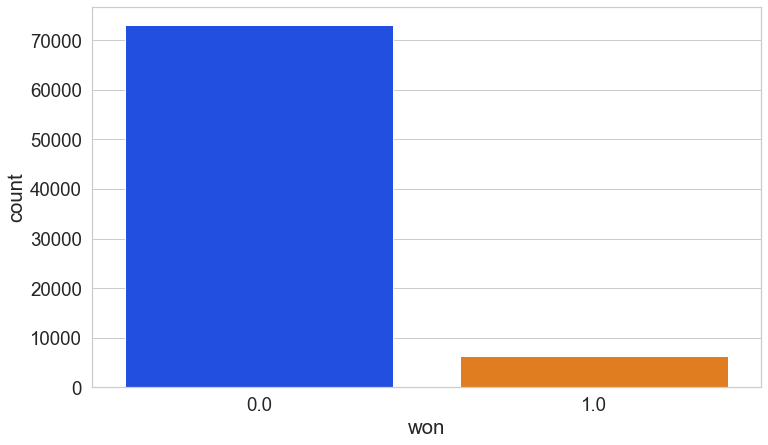

In [192]:
plt.figure(figsize=(12,7))
sns.countplot(data=data_runs, x='won', palette='bright')

In [193]:
count_0 = len(data_runs[data_runs['won']==0])
count_1 = len(data_runs[data_runs['won']==1])
pct_of_0 = count_0 / (count_0+count_1)
print("Проиграла: ", pct_of_0*100)
pct_of_1 = count_1/(count_0+count_1)
print("Выиграла: ", pct_of_1*100)

Проиграла:  91.99466310873916
Выиграла:  8.005336891260841


Можно сделать вывод, что данные несбалансированы

Посмотрим на диаграмму рассеивания для зависимости между шансом победы лошади перед началом забега и финишной позиции в забеге

# Посмотрим на пропущенные значения

In [195]:
data_runs.isna().sum()

won                    0
lengths_behind         0
horse_age              0
horse_country          2
horse_type             2
horse_rating           0
declared_weight        0
actual_weight          0
draw                   0
position_sec1          0
position_sec2          0
position_sec3          0
position_sec4      33221
position_sec5      69368
position_sec6      78151
behind_sec1            0
behind_sec2            0
behind_sec3            0
behind_sec4        33221
behind_sec5        69368
behind_sec6        78151
time1                  0
time2                  0
time3                  0
time4              33221
time5              69368
time6              78151
win_odds               0
place_odds          3735
dtype: int64

In [196]:
data_runs.fillna(data_runs.median(axis = 0), axis=0 , inplace=True)

In [197]:
data_runs.horse_country.fillna(data_runs.horse_country.mode().iloc[0], inplace=True)
data_runs.horse_type.fillna(data_runs.horse_type.mode().iloc[0], inplace=True)

Проверим результат проделанных манипуляций

In [198]:
data_runs.isna().sum()

won                0
lengths_behind     0
horse_age          0
horse_country      0
horse_type         0
horse_rating       0
declared_weight    0
actual_weight      0
draw               0
position_sec1      0
position_sec2      0
position_sec3      0
position_sec4      0
position_sec5      0
position_sec6      0
behind_sec1        0
behind_sec2        0
behind_sec3        0
behind_sec4        0
behind_sec5        0
behind_sec6        0
time1              0
time2              0
time3              0
time4              0
time5              0
time6              0
win_odds           0
place_odds         0
dtype: int64

# Категориальные признаки

In [199]:
hc_dummies = pd.get_dummies(data_runs.horse_country)
ht_dummies = pd.get_dummies(data_runs.horse_type)

In [200]:
hc_dummies

,ARG,AUS,BRZ,CAN,FR,GB,GER,GR,IRE,ITY,JPN,NZ,SAF,SPA,USA,ZIM
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79443,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
79444,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
79445,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [201]:
ht_dummies

,Brown,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
79442,0,0,0,1,0,0,0,0,0
79443,0,0,0,1,0,0,0,0,0
79444,0,0,0,1,0,0,0,0,0
79445,0,0,0,1,0,0,0,0,0


In [202]:
data_runs.drop(['horse_country', 'horse_type'], axis=1, inplace=True)
data_runs = pd.concat((data_runs, hc_dummies), axis=1)
data_runs = pd.concat((data_runs, ht_dummies), axis=1)

In [203]:
data_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 52 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   won              79447 non-null  float64
 1   lengths_behind   79447 non-null  float64
 2   horse_age        79447 non-null  int64  
 3   horse_rating     79447 non-null  int64  
 4   declared_weight  79447 non-null  float64
 5   actual_weight    79447 non-null  int64  
 6   draw             79447 non-null  int64  
 7   position_sec1    79447 non-null  int64  
 8   position_sec2    79447 non-null  int64  
 9   position_sec3    79447 non-null  int64  
 10  position_sec4    79447 non-null  float64
 11  position_sec5    79447 non-null  float64
 12  position_sec6    79447 non-null  float64
 13  behind_sec1      79447 non-null  float64
 14  behind_sec2      79447 non-null  float64
 15  behind_sec3      79447 non-null  float64
 16  behind_sec4      79447 non-null  float64
 17  behind_sec5 

# Нормализация

Воспользуемся линейным преобразованием, приводящем все значения к нулевому среднему и единичному среднеквадратичному отклонению

In [204]:
norm = (data_runs - data_runs.mean(axis = 0))/data_runs.std(axis = 0)
norm.describe()

,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,draw,position_sec1,position_sec2,position_sec3,...,ZIM,Brown,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan
count,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,...,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04
mean,1.800907e-16,-6.441268e-15,3.185956e-14,-3.872969e-14,-1.712356e-15,-3.874602e-15,1.362111e-16,4.381808e-17,7.649858e-17,1.938401e-16,...,-1.517767e-14,2.322265e-14,3.447295e-14,4.399669e-15,-2.126771e-14,5.236687e-15,-3.056130e-14,3.812651e-15,6.396766e-15,1.452883e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.949890e-01,-1.964817e-01,-1.527602e+00,-4.343844e+00,-6.607369e+00,-3.128962e+00,-1.567943e+00,-1.566495e+00,-1.566239e+00,-1.565744e+00,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,-4.376499e+00,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
25%,-2.949890e-01,-1.295895e-01,-3.870437e-01,-8.808600e-02,-6.889370e-01,-7.500847e-01,-7.674281e-01,-7.631418e-01,-7.625986e-01,-7.618973e-01,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,2.284903e-01,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
50%,-2.949890e-01,-6.269734e-02,-3.870437e-01,-8.808600e-02,-4.737260e-02,4.287431e-02,3.308650e-02,4.021131e-02,4.104165e-02,4.194932e-02,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,2.284903e-01,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
75%,-2.949890e-01,1.905979e-02,-3.870437e-01,-8.808600e-02,6.583483e-01,8.358334e-01,8.336011e-01,8.435644e-01,8.446819e-01,8.457959e-01,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,2.284903e-01,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
max,3.389915e+00,2.951852e+01,7.596867e+00,6.550897e+00,4.235070e+00,1.628792e+00,2.167792e+00,1.914702e+00,1.916202e+00,1.917591e+00,...,8.136031e+01,6.153691e+00,1.610834e+01,4.297187e+01,2.284903e-01,6.835418e+01,8.466770e+00,1.824299e+01,2.269104e+01,4.067094e+01


# Делим на обучающую и тестовую выборки

In [206]:
X = data_runs.drop('won', axis = 1) # выбрасываем столбец 'won'

y = data_runs['won']
feature_names = X.columns
feature_names

Index(['lengths_behind', 'horse_age', 'horse_rating', 'declared_weight',
       'actual_weight', 'draw', 'position_sec1', 'position_sec2',
       'position_sec3', 'position_sec4', 'position_sec5', 'position_sec6',
       'behind_sec1', 'behind_sec2', 'behind_sec3', 'behind_sec4',
       'behind_sec5', 'behind_sec6', 'time1', 'time2', 'time3', 'time4',
       'time5', 'time6', 'win_odds', 'place_odds', 'ARG', 'AUS', 'BRZ', 'CAN',
       'FR', 'GB', 'GER', 'GR', 'IRE', 'ITY', 'JPN', 'NZ', 'SAF', 'SPA', 'USA',
       'ZIM', 'Brown', 'Colt', 'Filly', 'Gelding', 'Grey', 'Horse', 'Mare',
       'Rig', 'Roan'],
      dtype='object')

In [207]:
X = X.to_numpy()
y = np.array(y)

In [208]:
print(X.shape)
print(y.shape)
N, d = X.shape

(79447, 51)
(79447,)


In [209]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 404)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

print(N_train, N_test)

55612 23835


# Применим Logistic Regression

In [210]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(max_iter=700)
LogReg.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=700)

In [211]:
error_train = np.mean(y_train != LogReg.predict(X_train))
error_test  = np.mean(y_test  != LogReg.predict(X_test))
print('Error on train = ', error_train)
print('Error on test = ', error_test)

Error on train =  0.0022656980507804072
Error on test =  0.002181665617788966


Проверим вариант решения задачи, что модель везде ставит предикт - 0

In [212]:
y_train_list = y_train.tolist()

In [213]:
y_train_list.count(1.0) / y_train_list.count(0.0)

0.0879355204726412

Доля значений "1" - 8%, это показывает, что модель смогла обучиться

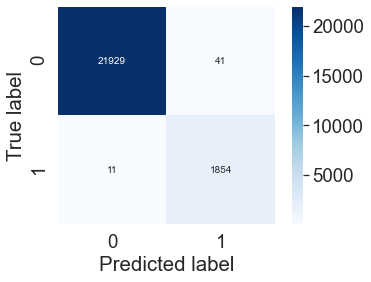

In [214]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, LogReg.predict(X_test)), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True label")
pass

# Построим нейронную сеть и подберём параметры

In [215]:
from sklearn.neural_network import MLPClassifier
alpha_arr = np.logspace(-2, 5, 10)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(hidden_layer_sizes = (4, 4), max_iter=404, random_state = 404, alpha = alpha)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

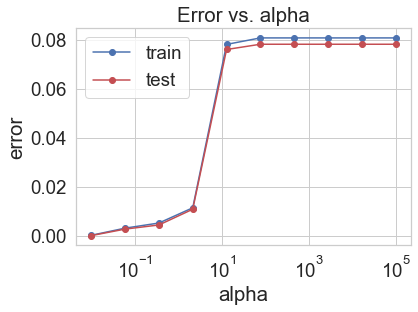

In [216]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

Посмотрим соотношение ошибок

In [217]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.00041357980292023303 0.0002936857562408223
